# __Time Series Analysis with LSTM using Python's Keras Library__

Bu deneme, Usman Malik'in Stack Abuse [içeriğinden](https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/) faydalanılarak oluşturulmuştur.

Bu denemede kullanılan veri seti ["Yahoo Finance"](https://finance.yahoo.com/quote/AAPL/history?period1=1356912000&period2=1514764800&interval=1d&filter=history&frequency=1d) sayfasından indirilmiştir. (Üzerine tıklayarak veriye ulaşabilirsiniz.) Algoritmayı eğitmek için 1 Ocak 2013 - 31 Aralık 2017 tarihleri arası Apple hisse senedi fiyatları, tahminleme yapmak için Ocak 2018 ayına ait Apple hisse senedi fiyarları kullanılmıştır. İndirilen veri setinde; Data, Open, High, Low, Close, Adj Close ve Volume değişkenlerinden oluşan 7 adet kolon mevcuttur. Öngörü işlemi için açılış hisse senedi fiyatı olan Open verileri kullanılacaktır. 

##### Veriyi Önizleme

In [1]:
#Veriyi daha iyi görebilmek için pandas kütüphanesini yüklüyoruz.
import pandas as pd 

In [2]:
df = pd.read_csv('Dataset.csv') #pandas'ın csv okuma özelliğiyle verisetimizi okutup dataframe olarak tanımlıyoruz.
df.head() #dataframe değişkenimize head() ekleyerek tablonun ilk 5 değerini önizleme yapıyoruz. 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,79.117142,79.285713,77.375717,78.432854,68.502106,140129500
1,2013-01-03,78.268570,78.524284,77.285713,77.442856,67.637436,88241300
2,2013-01-04,76.709999,76.947144,75.118568,75.285713,65.753418,148583400
3,2013-01-07,74.571426,75.614288,73.599998,74.842857,65.366646,121039100
4,2013-01-08,75.601425,75.984283,74.464287,75.044289,65.542587,114676800


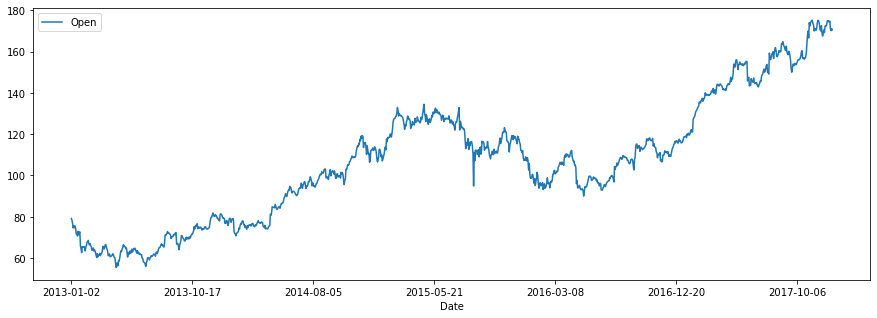

In [3]:
#pandas'ın plot özelliği ile grafiğimizin özelliklerini belirliyoruz.
#kind=line diyerek çizgi grafiği istediğimizi belirtiyoruz. X ve Y düzlemlerine aktaracağımız değişkenleri tanımlıyoruz.
#Açılış verileriyle çalışacağımız için Open değişkenini ve Date değişkenini tanımlıyoruz.
#figsize=() diyerek grafiğin x ve y eksen boyutlarını belirtiyoruz. (daha geniş şekilde grafiği görebilmek için (15,5) olarak belirledim.)
df.plot(kind='line', x='Date', y='Open', figsize=(15,5)) 

Grafikte trendin çok doğrusal olmadığı görülmektedir, bu bilgilerle eğilimi yakalamak zordur. LSTM'nin gücünü burada kullanabiliriz. 
LSTM (Uzun Kısa Süreli Bellek), geçmiş bilgileri hatırlayabilen ve gelecekteki değerleri tahmin ederken bu geçmiş bilgileri dikkate alan bir derin öğrenme modelidir.

##### Kütüphanelerin Yüklenmesi

In [4]:
import numpy as np              #Çok boyutlu diziler ve matrisler için destek içerek yüksek düzeyli matematiksel fonksiyonların geniş bir kütüphanesidir.
import matplotlib.pyplot as plt #numpy için bir çizim kütüphanesidir. 
import pandas as pd             #kullanımı kolay veri yapıları ve veri analiz araçları sağlayan, zaman serileri analizinde de kullanılan bir kütüphanedir. 

##### Verisetini İçe Aktarma

In [5]:
#verisetimizi ilk başta yaptığımız gibi pandas'ın csv okuma özelliği ile tanımlıyoruz ve önizlemesini alıyoruz.
apple_traning_dataset = pd.read_csv('dataset.csv')
apple_traning_dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,79.117142,79.285713,77.375717,78.432854,68.502106,140129500
1,2013-01-03,78.268570,78.524284,77.285713,77.442856,67.637436,88241300
2,2013-01-04,76.709999,76.947144,75.118568,75.285713,65.753418,148583400
3,2013-01-07,74.571426,75.614288,73.599998,74.842857,65.366646,121039100
4,2013-01-08,75.601425,75.984283,74.464287,75.044289,65.542587,114676800


In [6]:
#verisetimiz hakkında bilgilendirme. Değişkenleri sayısı, türü, boş değer içerip içermediğini gösterir. 
apple_traning_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [7]:
#verimizde sadece açılış değerlerini kullancağımız için verisetini numpy ile Open kolonunu alarak yeni bir işlenmiş değişken tanımlıyoruz ve önizlemesini alıyoruz.
apple_traning_processed = apple_traning_dataset.iloc[:, 1:2].values

##### Veri Normalizasyonu

Bir sinir ağını kullanırken verilerimizi normalleştirmeli veya ölçeklendirmeliyiz. Verilerimizi 0 ile 1 arasında ölçeklendirmek için MinMaxScalar kütüphanesinden sklear.preprocessing sınıfını kullacağız. 

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1)) #feature_range ile verilerin aralığını belirtiyoruz.
apple_traning_scaled = scaler.fit_transform(apple_traning_processed) #en son işlediğimiz değişkenimize normalize transform işlemini yapıp yeni bir değişkene atıyoruz.

##### Eğitim Veriseti Belirleme 

Modelimizi eğitmeden önce eğitim ve test verilerimizi belirleyip ayarlamalıyız. Bu denemede, son 60 güne ait açılış hisse senedi fiyatlarına dayanarak verilerin tahminlemesi sağlayacağız. Farklı sayılarla da test edebilir ve algoritmanızın nasıl performans gösterdiğini deneyebilirsiniz. 

In [10]:
features_set = [] #input
labels = [] #output
for i in range(60, 1259):
    features_set.append(apple_traning_scaled[i-60:i, 0])
    labels.append(apple_traning_scaled[i, 0])
#eğitim verimizde 1259 veri bulunmaktadır. 61. kayıttan başlayan ve önceki 60 kaydın tamamını feature_set e kaydeden bir döngü oluşturduk. 

In [11]:
features_set, labels = np.array(features_set), np.array(labels) #son değişkenlerimizi numpy dizisine çeviriyoruz

In [12]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
#Modeli eğitmeye başlamadan verilerimizi LSTM ile çalışabilecek şekle dönüştürmeliyiz.
#Verilerimizi üç boyutlu şekle dönüştürmeliyiz.
#ilk boyut, 1259 verimizin sıralanma numaraları
#ikinci boyut, 60 olan zaman adımı sayısı
#son boyut ise gösterge sayısıdır.

#### __LSTM'nin Eğitimi__

Verilerimizi işledik ve istediğimiz biçimlere dönüştürdük. Şimdi LSTM'imizi oluşturmanın tam zamanı. Oluşturacağımız LSTM modeli, çoklu katmanlara sahip sıralı bir model olacaktır. Modelimize 4 LSTM katmanı ve ardından gelecekteki hisse senedi fiyatını öngören bir yoğun katman(dense layer) ekleyeceğiz. 

Öncelikle modelimizi oluşturmak için ihtiyaç duyduğumuz kütüphaneleri aktaralım:

In [13]:
#Keras kütüphanesi arkaplanda TensorFlow'u kullanacaktır. 
from keras.models import Sequential #Sequential, her katmanın tam olarak bir giriş tensörüne ve bir çıkış tensörüne sahip olduğu düz bir katman yığını için uygundur.
from keras.layers import Dense #Dense, düzenli olarak derinden bağlı sinir ağı katmanıdır. Çok kullanılan bir tabakadır. 
                               #Dense, girişte aşağıdaki işlemi yapar ve çıktıyı döndürür.
                               # output = activation(dot(input, kernel) + bias)
from keras.layers import LSTM  #LSTM, bir çeşit tekrarlayan sinir ağıdır. Zamana ve diziye bağlı davranışları modellemeye ve tahminlemeye çalışa bir sinir ağıdır.
from keras.layers import Dropout # Dropout, bir modelin ezberlemesini(overfitting) önlemek için kullanılan bir tekniktir.
                                # Eğitim aşamasının her güncellemesinde gizli birimlerin outgoing edges değerlerini rastgele olarak 0'a ayarlayarak çalışır.

Using TensorFlow backend.


İlk olarak Sequential'i tanımlamamız gerekir. Bu bizim model sınıfımız olacak ve bu modele LSTM, Dropout ve Dense katmanları ekleyeceğiz.

In [14]:
model = Sequential()

##### LSTM ve Dropout Katmanlarını Oluşturma

In [15]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))
# Sequential modele bir katman eklemek için "add" yöntemi kullanılır ve yukarıda add yöntemi ile modelimize LSTM katmanımızı ekledik.
# LSTM katmanının ilk parametresi(units=50), katmanda istediğimiz nöron sayısıdır.
# İkinci parametre(return_sequences), modele daha fazla katman ekleyeceğimiz için True olarak ayarlanmıştır. 
# input_shape'inilk parametresi zaman adımlarının sayısı, son parametre göstergelerin(indicators) sayısıdır.

In [16]:
model.add(Dropout(0.2))
# yukarıda belirttiğimiz gibi Dropout, ezberlemenin(overfitting) önüne geçerek daha iyi bir traning yapmayı sağlar. 

In [17]:
# 3 tane daha LSTM modeli ve dropout katmanı ekliyoruz.
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

##### Dense Katmanını Oluşturma

Modelimizi daha sağlam hale getirmek için modelin sonuna dense katmanını ekliyoruz. Dense katmanındaki nöron sayısını 1'e eşitliyoruz çünkü çıktıda tek bir değer tahmin etmek istiyoruz.

In [19]:
model.add(Dense(units = 1))

##### Model Derleme

Son olarak training verileri eğitebilmemiz için LSTM'yi compile işlemine dahil ederek derlememiz gerekmektedir. 
<br> Modelimize 'compile' metodunu ekliyoruz. Kayıp fonksiyonu olarak loss değerinde 'ortalama hata karesini(MSE)' kullandık ve kaybı azaltmak veya algoritmayı optimize etmek için de optimizer değişkeninde 'adam' optimizerını kullandık. 
<br> Probleme göre farklı 'loss' veya 'optimizer' parametreleri kullanılabilir. 
<br> Yukarıda kullandığımız Adam optimizasyonu, birinci ve ikinci dereceden momentlerin uyarlamalı tahminine dayanan stokastik bir gradyan iniş yöntemidir.

In [20]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

##### Algoritma Eğitimi

Modelimizi eğitirken fit methodunu kullanıyoruz ve belirli hiperparametrelerimizi tanımlıyoruz.
<br>Bu işlem donanıma bağlı olarak biraz zaman alabilir.
<br> __Epochs;__ eğitimin tur, döngü sayısıdır. Modelde ilk parça eğitilir ve elde ettiği başarıma göre geriyayılım(backpropagation) ile ağırlıklar güncellenir. Bu işlem belirlenen sayı kadar devam eder. Eğitim işleminin doğruluğu başlarda artıp sonrasında doğruluğu azalmaya başlayıp overfitting olabilir, bu noktada doğruluğun en yüksek olduğu yerde epoch sayımız uygundur. 
<br>__Batch;__ ağa verilen alt örneklem sayısıdır. Batch değerinin yüksek olması doğru gradyan değerinin hesaplanmasını sağlamaktadır ancak belirlediğimiz batch değerinin GPU belleğine sığması gerekiyor. Bu yüzden batch boyutunu 2'nin katları şekilde belirlenir genelde 64 ile 512 arasında belirlenir. Eğitim kümesindeki eleman sayısına göre de değiştirilebilir. 

In [21]:
model.fit(features_set, labels, epochs = 100, batch_size = 32)

Epoch 1/100
1199/1199 [==============================] - 9s 7ms/step - loss: 0.0274
Epoch 2/100
1199/1199 [==============================] - 7s 6ms/step - loss: 0.0059
Epoch 3/100
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0054
Epoch 4/100
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0043
Epoch 5/100
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0042
Epoch 6/100
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0048
Epoch 7/100
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0045
Epoch 8/100
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0036
Epoch 9/100
1199/1199 [==============================] - 8s 7ms/step - loss: 0.0040
Epoch 10/100
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0036
Epoch 11/100
1199/1199 [==============================] - 6s 5ms/step - loss: 0.0036
Epoch 12/100
1199/1199 [==============================] - 6s 5ms/step - lo

#### __LSTM'yi Test Etme__

LSTM'yi eğitme işlemi bittikten sonra şimdi Ocak 2018 ayı için açılış hisse senedi fiyatlarını tahmin ederek algoritmanın test setindeki performansını ölçme zamanı. 
<br>Test verilerimizi içe aktarıp, en başta yaptığımız gibi 'iloc' methodu ile sadece Open değerlerimizi belirliyoruz. 

In [24]:
apple_testing_complete = pd.read_csv('Dataset_testing.csv')
apple_testing_processed = apple_testing_complete.iloc[:, 1:2].values

Test veri setimizi dataframe yaparak hem tablo şeklinde görüntüleyip hem de grafiğini görüntüleyelim.

In [37]:
df_testing = pd.read_csv('Dataset_testing.csv')
df_testing.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,170.160004,172.300003,169.259995,172.259995,166.353714,25555900
1,2018-01-03,172.529999,174.550003,171.960007,172.229996,166.324722,29517900
2,2018-01-04,172.539993,173.470001,172.080002,173.029999,167.097290,22434600
3,2018-01-05,173.440002,175.369995,173.050003,175.000000,168.999741,23660000
4,2018-01-08,174.350006,175.610001,173.929993,174.350006,168.372040,20567800


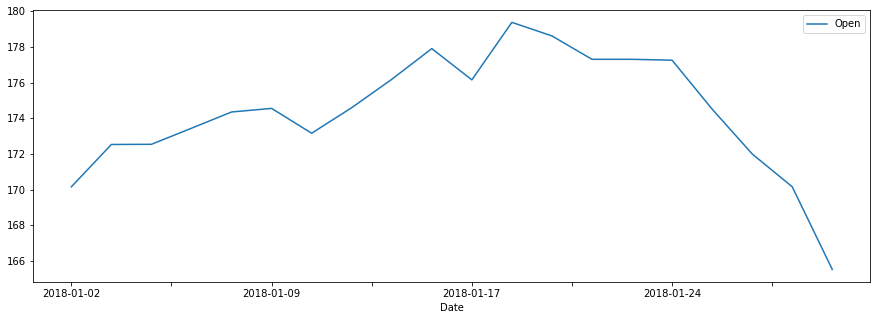

In [34]:
df_testing.plot(kind='line', x='Date', y='Open', figsize=(15,5))

Grafikte trendin oldukça doğrusal olmadığını görebilirsiniz. Genel olarak hisse senedi fiyatlarında ayın başında küçük bir artış ve ardından ay sonunda düşüş eğilimi görülürken, burada aradaki zaman aralıklarında da hisse senedi fiyatlarında hafif bir artış ve azalışlar görülmektedir. Böyle bir eğilimi tahmin etmek oldukça zordur. Eğittimiz LSTM böyle bir eğilimi tahmin edebilecek mi test edelim.

##### Test Verilerini Dönüştürme

Ocak 2018'in her günü için feature setimizin önceki 60 güne ait açılış hisse senedi fiyatlarını içermesini istiyoruz. 
<br>Bunu yapmak için eğitim verilerimizi birleştirmemiz ve verileri test etmemiz gerekiyor.
<br> Bunun içinde pandas'ın concat methodunu uyguluyoruz.

In [35]:
apple_total = pd.concat((apple_traning_dataset['Open'], apple_testing_complete['Open']), axis=0)

Ocak ayına ait her bir girdimiz için önceki 60 güne ait hisse senedi fiyatlarını içermelidir. Ocak 2018 ayı için 20 test günü mevcut ve eğitim seti için de aldığımız son 60 günün 60 hisse senedi fiyatını açmamız gerekiyor.

In [38]:
test_inputs = apple_total[len(apple_total) - len(apple_testing_complete) - 60:].values

In [41]:
test_inputs #oluşturduğumuz test_inputs'a baktığımızda 20 test seti ve 60 eğitim setinin birleştiği şekilde 80 adet veri bulunmaktadır.

array([154.179993, 154.970001, 155.809998, 156.059998, 155.970001,
       156.350006, 156.729996, 157.899994, 159.779999, 160.419998,
       156.75    , 156.610001, 156.889999, 156.289993, 156.910004,
       157.229996, 159.289993, 163.889999, 167.899994, 169.869995,
       166.600006, 174.      , 172.369995, 173.910004, 174.660004,
       175.110001, 175.110001, 173.5     , 173.039993, 169.970001,
       171.179993, 171.039993, 170.289993, 170.779999, 173.360001,
       175.100006, 175.050003, 174.300003, 172.630005, 170.429993,
       169.949997, 172.479996, 169.059998, 167.5     , 169.029999,
       170.490005, 169.199997, 172.149994, 172.5     , 172.399994,
       173.630005, 174.880005, 175.029999, 174.869995, 174.169998,
       174.679993, 170.800003, 170.100006, 171.      , 170.520004,
       170.160004, 172.529999, 172.539993, 173.440002, 174.350006,
       174.550003, 173.160004, 174.589996, 176.179993, 177.899994,
       176.149994, 179.369995, 178.610001, 177.300003, 177.300

En başlarda eğitim seti için yaptığımız gibi test verilerimizi de ölçeklendirmeliyiz.

In [42]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

Veriyi ölçeklendirdikten sonra şimdi Ocak ayı için önceki 60 hisse senedi fiyatlarını içerecek son test giriş setimizi hazırlayalım.

In [44]:
test_features = []
for i in range(60, 80):
    test_features.append(test_inputs[i-60:i, 0])

Son olarak verileri LSTM'ye girdi olarak kullanabilecek üç boyutlu formata dönüştürmeliyiz.

In [45]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

#### __Tahmin Yapma__

Öncelikle bu işlemi yapmak için oluşturduğumuz test_features setimize model.predict metodunu uygulamalıyız.

In [47]:
predictions = model.predict(test_features)

Verileri ölçeklendirdiğimiz için LSTM tarafından yapılan tahminler de ölçeklendirilmektedir. Ölçekli tahmin değerlerini inverse_transform ile gerçek değerlere dönüştürüyoruz.

In [48]:
predictions = scaler.inverse_transform(predictions)

Son olarak tahmin edilen değerleri gerçek değerlerle karşılaştıralım. Bunun için de matplot kütüphanesinin grafiklerinden faydalanıyoruz.

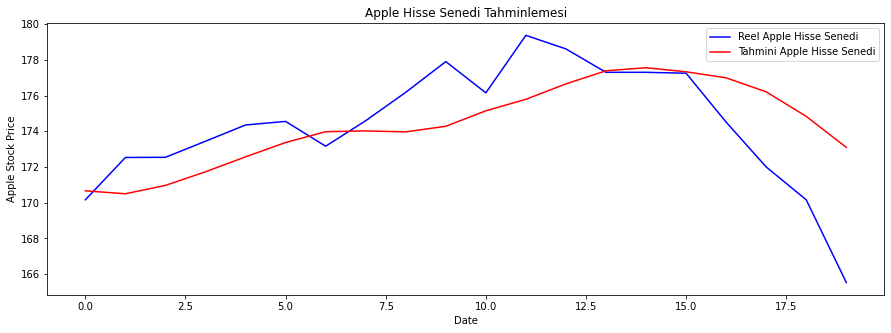

In [52]:
plt.figure(figsize=(15,5))
plt.plot(apple_testing_processed, color='blue', label='Reel Apple Hisse Senedi')
plt.plot(predictions , color='red', label='Tahmini Apple Hisse Senedi')
plt.title('Apple Hisse Senedi Tahminlemesi')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

Çok yakın tahminler olmasa da algoritmanın genel eğilimi yakalayabildiğini söyleyebiliriz.

### Kaynakça

Bu çalışma hazırlanırken aşağıdaki içeriklerden faydalanılmıştır.
<br>https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
<br>https://keras.io/guides/
<br>https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab#:~:text=Dropout%20is%20a%20technique%20used,update%20of%20the%20training%20phase.
<br>https://devhunteryz.wordpress.com/2018/08/27/yapay-sinir-aglarindaki-hiperparametreler/
<br>https://medium.com/deep-learning-turkiye/derin-ogrenme-uygulamalarinda-en-sik-kullanilan-hiper-parametreler-ece8e9125c4
